# Jupyter Notebook - Kaggle Data Set

Dieses Notebook dient als "Analyse". Erst wird ein Datenset von Kaggle via API runtergeladen, dann wird dieses Datenset (via Python!) verunreinigt, wieder gereinigt und dann wird dieses Datenset allgemein analysiert. Im nächsten Schritt werden zusätzliche Daten eingelesen und die Fragen, welche im ETL-Prozess definiert wurden werden beantwortet. Zusätzlich werden die Daten in eine SQL-Datenbank eingelesen (MariaDB).




Abschnitte:
- Import & Installs
- Datenimport von Kaggle
- Datenverunreinigung
- Data Cleaning
- Datenanalyse Kaggle-Datenset
- DB-Connection
- Zusammenführung Datensets/Beantwortung der definierten Fragen

## Imports & Installs

In [150]:
#!pip install matplotlib
#!pip install kaggle
#!pip install seaborn
#!pip install pingouin
#sudo apt-get install libmariadb3 libmariadb-dev #to install MariaDB Connector/C, welches eine Dependency ist
#!pip install mariadb
#!pip install openpyxl
#!pip install xlsxwriter

import openpyxl
import os
import io
import xlsxwriter
import pandas as pd
import numpy as np
import kaggle
import pingouin as pg
import matplotlib
import mariadb
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
from scipy import stats
from matplotlib.cbook import boxplot_stats
from kaggle.api.kaggle_api_extended import KaggleApi

## Datenimport von Kaggle

Mit folgendem Code wird das Datenset, welches unter *https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year* zu finden ist via API heruntergeladen. Es wird danach wie gemäss Projektbeschrieb unter dem Namen *fileName*_src.csv gespeichert. Das Datenset beinhaltet die Top-Songs von Spotify pro Jahr, für die Jahre 2010 bis 2019.

Achtung: Es erscheint hier noch eine Meldung, dass mein Kaggle API Key von anderen Usern auf diesem System ebenfalls lesbar sei. Das spielt hier keine Rolle (keine anderen User und der Key wird sowieso wieder gelöscht werden), weshalb nichts dagegen unternommen wurde. Meine Linux-Kenntnisse sind zu gering um abzuschätzen, ob es zu Problemen führen könnte, wenn dieses Jupyter Notebook dann auf einem anderen Computer ausgeführt würde.

In [151]:
# Hier müssen eigene Credentials hinterlegt werden
api = KaggleApi()
api.authenticate()
api.dataset_download_files('leonardopena/top-spotify-songs-from-20102019-by-year', path='Workingdata', unzip=True)


!mv Workingdata/top10s.csv Workingdata/top10s_src.csv #rename das File entsprechend der Doku
current_directory = os.getcwd()
top_ten_src = pd.read_csv(current_directory + '/Workingdata/top10s_src.csv') #File einlesen

Werfen wir mal einen Blick auf das Datenset:

In [152]:
top_ten_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  603 non-null    int64 
 1   title       603 non-null    object
 2   artist      603 non-null    object
 3   top genre   603 non-null    object
 4   year        603 non-null    int64 
 5   bpm         603 non-null    int64 
 6   nrgy        603 non-null    int64 
 7   dnce        603 non-null    int64 
 8   dB          603 non-null    int64 
 9   live        603 non-null    int64 
 10  val         603 non-null    int64 
 11  dur         603 non-null    int64 
 12  acous       603 non-null    int64 
 13  spch        603 non-null    int64 
 14  pop         603 non-null    int64 
dtypes: int64(12), object(3)
memory usage: 70.8+ KB


In [153]:
top_ten_src.describe()

,Unnamed: 0,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000,603.000000
mean,302.000000,2014.592040,118.545605,70.504146,64.379768,-5.578773,17.774461,52.225539,224.674959,14.326700,8.358209,66.520730
std,174.215384,2.607057,24.795358,16.310664,13.378718,2.798020,13.102543,22.513020,34.130059,20.766165,7.483162,14.517746
min,1.000000,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000
25%,151.500000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,35.000000,202.000000,2.000000,4.000000,60.000000
50%,302.000000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,221.000000,6.000000,5.000000,69.000000
75%,452.500000,2017.000000,129.000000,82.000000,73.000000,-4.000000,24.000000,69.000000,239.500000,17.000000,9.000000,76.000000
max,603.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,98.000000,424.000000,99.000000,48.000000,99.000000


In [154]:
top_ten_src.head()

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


In [155]:
len(top_ten_src)

603

Das Datenset hat also 603 Einträge und 15 Attribute, wovon 12 Integers sind und 3 Objects. Die describe()-Funktion wurde lediglich für eine kurze Übersicht genutzt, vorwiegend um den Inhalt der Attribute etwas besser zu verstehen. Auch die head()-Funktion dient diesem Zweck. Nun noch eine Erläuterung bezüglich der Attribute:



| Kürzel | Erklärung |
|:---:|:---:|
| Unnamed: 0 | ID |
| title | Songtitel |
| artist | Interpret |
| top genre | Genre des Songs |
| year | Jahr, in welchem der Song in den Charts war |
| bpm | Beats per Minute (Geschwindigkeit des Songs) |
| nrgy | Die "Energie" des Songs - je höher diese Zahl desto "ergetischer" der Song |
| dnce | "Tanzbarkeit" - je höher dieser Wert, desto einfacher ist es, zu diesem Song zu tanzen |
| dB | Dezibel |
| live | "Liveness" - je höher dieser Wert, desto wahrscheinlicher, dass der Song eine Liveaufnahme ist |
| val | Valenz - je höher dieser Wert, desto positiver ist die Stimmung des Songs |
| dur | Sekunden - dauer des Songs in Sekunden |
| acous | Akkustik - je höher d ieser Wert, desto akkustischer ist der Song |
| spch | Sprechmenge - je höher dieser Wert, desto mehr gesprochene Worte sind im Song enthalten |
| pop | Popularität - je höher dieser Wert, desto populärer der Song |

## Datenverunreinigung

Ohne die Daten bereits nach Nullvalues etc. durchsucht zu haben ist davon auszugehen, dass das Datenset "zu rein" ist, da es von Kaggle kommt. Deshalb wird hier das Datenset verunreinigt. Mein Ziel war es, ca. 50 "verunreinigte" Zellen zu haben. Dies beinhaltet:
- Doppelte Zeilen
- NaN-Values
- Ausreisser

Das Datenset hat schon gewisse "Unreinheiten". So existiert beispielsweise das Gerne "detroit hip hop", wobei alle Songs des Genres "Hip Hop", unter diesem erfasst werden könnten. Ebenfalls gibt es beispielsweise ein "belgian edm" Genre, welches unter dem Genre "edm" erfasst werden könnte. Aber dies werde ich bei der Datenbereinungen anschauen.

Ziel der Datenverunreinigung ist es, diese dynamisch zu gestalten, so dass die bei jedem Durchlauf unterschiedlich ausfällt (nicht immer die gleichen Zeilen und die gleiche Menge an Zellen verunreinigt werden).

In [156]:
top_ten_src_dirty = pd.read_csv('Workingdata/top10s_src.csv')

#Am 'val'-Attribut bin ich nicht interessiert, ich produziere dort deshalb einige Ausreisser. Der max-Value liegt bei
#98, der min-Value bei 35. Deshalb werden in zufälligen Zeilen zufällige Zahlen über 150 (bis 300) und unter 2 eingefügt.
#Wenn z gerade ist wird eine tiefe Nummer zugewiesen, ist z ungerade wird ein hoher Outlier eingefügt

i = randint(6, 12)
z = 0

while z <= i:
    line_number = randint(0, len(top_ten_src_dirty))
    
    if z % 2 == 0:
        low_int = randint(0, 1)
        top_ten_src_dirty.loc[[line_number],['val']] = low_int
        
    else:
        high_int = randint(150, 300)
        top_ten_src_dirty.loc[[line_number],['val']] = high_int

    z += 1
    del line_number

#Ich mag es, i und z als Dummy-Variabeln zu benutzen, deshalb lösch ich die hier gleich wieder
del i
del z

In [157]:
#Selbiges wie vorher können wir auch noch mit nan-Values machen. Hierfür wähle ich die dB-Column.

i = randint(6, 18)
z = 0

while z <= i:
    line_number = randint(0, len(top_ten_src_dirty))
    top_ten_src_dirty.loc[[line_number],['dB']] = np.nan
    z += 1
    del line_number

#Ich mag es, i und z als Dummy-Variabeln zu benutzen, deshalb lösch ich die hier gleich wieder
del i
del z

In [158]:
#Diese Schleife wählt zufällig zwischen 6 und 12 Rows (ebenfalls zufällig) aus dem existierenden, heruntergeladenen
#Datenset, und kopiert sie in eine Liste. Die Schlaufe dient dazu, das Datenset mit doppelten Rows zu "verunreinigen".
i = randint(6, 12)
z = 0
double_rows = [] 
while z <= i:
    line_number = randint(0, len(top_ten_src_dirty))
    double_rows.append(top_ten_src.loc[line_number].values.tolist())
    z += 1
    del line_number

#Ich mag es, i und z als Dummy-Variabeln zu benutzen, deshalb lösch ich die hier gleich wieder
del i
del z
    
#Dann fügen wir die beiden DFs zusammen
dataframe_double_rows = pd.DataFrame(double_rows, columns=['Unnamed: 0','title','artist','top genre','year','bpm','nrgy','dnce','dB','live','val','dur','acous','spch','pop'])
frames = [top_ten_src_dirty, dataframe_double_rows]
top_ten_src_dirty = pd.concat(frames)

In [159]:
#Das Datenset erstmal ordentlich durchmischen (Ordnung nach Jahr geht verloren)

#Dies wollte ich ursprünglich noch machen. Allerdings soll man ja den Dozenten die Arbeit erleichtern, indem man
#verunreinigte Files und gefühlte 8900908 weitere Files irgendwo speichert. Ich machs mir nun auch einfach und
#lasse das sein, ansonsten kann ich die schmutzigen Zeilen nicht finden.
#top_ten_src_dirty = top_ten_src_dirty.sample(frac = 1).reset_index(drop = True)

In [160]:
#Exportieren und als .csv abspeichern (ohne Index)
top_ten_src_dirty.to_csv('Workingdata/top_ten_src_dirty.csv', index = False)

Hiermit dürfe die Verunreinigung des Datensets abgeschlossen sein.

## Data Cleaning

Nun soll das "künstlich" verunreinigte Datenset wieder gereinigt werden. Dies geschieht in diesem Abschnitt.

Ziel des Datacleanings ist es, dies dynamisch zu gestalten, so dass der Code wiederverwendbar wäre (bzw. dass die dynamisch generierten "Verschmutzungen" in jedem Fall bereinigt werden.

In [161]:
#Dirty CSV laden
df_top_ten = pd.read_csv('Workingdata/top_ten_src_dirty.csv')

#Mal die info()-Funktion aufrufen um zu schauen, was wir hier überhaupt haben
df_top_ten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  612 non-null    int64  
 1   title       612 non-null    object 
 2   artist      612 non-null    object 
 3   top genre   612 non-null    object 
 4   year        612 non-null    int64  
 5   bpm         612 non-null    int64  
 6   nrgy        612 non-null    int64  
 7   dnce        612 non-null    int64  
 8   dB          603 non-null    float64
 9   live        612 non-null    int64  
 10  val         612 non-null    int64  
 11  dur         612 non-null    int64  
 12  acous       612 non-null    int64  
 13  spch        612 non-null    int64  
 14  pop         612 non-null    int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 71.8+ KB


In [162]:
#Mal schauen, was sich in den Attributen verbirgt, bzw. das Datenset vollstänig anschauen
df_top_ten

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5.0,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,6,Baby,Justin Bieber,canadian pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,7,Dynamite,Taio Cruz,dance pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,8,Secrets,OneRepublic,dance pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,9,Empire State of Mind (Part II) Broken Down,Alicia Keys,hip pop,2010,93,37,48,-8.0,12,14,216,74,3,76
9,10,Only Girl (In The World),Rihanna,barbadian pop,2010,126,72,79,-4.0,7,61,235,13,4,73


In [163]:
#Lassen wir noch den describe()-Befehl laufen um einen "statistischen" Überblick über die Inhalte der Spalten zu haben
df_top_ten.describe()

,Unnamed: 0,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
count,612.000000,612.000000,612.000000,612.000000,612.000000,603.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000
mean,302.179739,2014.594771,118.431373,70.529412,64.468954,-5.575456,17.761438,53.450980,224.539216,14.245098,8.367647,66.562092
std,174.296849,2.609784,24.713617,16.253539,13.387246,2.797518,13.071199,29.542932,34.146216,20.664621,7.468458,14.498414
min,1.000000,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,134.000000,0.000000,0.000000,0.000000
25%,150.750000,2013.000000,100.000000,61.000000,57.000000,-6.000000,9.000000,34.750000,202.000000,2.000000,4.000000,60.000000
50%,302.500000,2015.000000,120.000000,74.000000,66.000000,-5.000000,12.000000,52.000000,220.000000,6.000000,5.500000,69.000000
75%,453.250000,2017.000000,129.000000,82.000000,73.250000,-4.000000,24.000000,70.000000,239.000000,17.000000,9.000000,76.000000
max,603.000000,2019.000000,206.000000,98.000000,97.000000,-2.000000,74.000000,284.000000,424.000000,99.000000,48.000000,99.000000


In [164]:
#Die Spalte "Unnamed: 0" scheint eine aufsteigende Nummer zu sein, vermutlich ist dies der ursprüngliche Index.
#Sie wird nicht hilfreich sein, deshalb wird sie gedropt.
df_top_ten.drop(columns={'Unnamed: 0'}, inplace=True)
df_top_ten

,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5.0,52,64,263,24,23,82
2,TiK ToK,Kesha,dance pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,Baby,Justin Bieber,canadian pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,Dynamite,Taio Cruz,dance pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,Secrets,OneRepublic,dance pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,hip pop,2010,93,37,48,-8.0,12,14,216,74,3,76
9,Only Girl (In The World),Rihanna,barbadian pop,2010,126,72,79,-4.0,7,61,235,13,4,73


In [165]:
#Nun noch die Spalten etwas klarer benennen. Vor allem die "top genre" nervt mich, sie soll nur "genre" heissen.
df_top_ten.rename(columns={'top genre':'genre'}, inplace=True)

In [166]:
#Nun nach Missing Values und NaN-Values suchen.
df_top_ten[df_top_ten.isna().any(axis=1)]

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
113,We Are Never Ever Getting Back Together,Taylor Swift,pop,2012,86,68,63,NaN,12,75,193,1,9,75
210,All of Me,John Legend,neo mellow,2014,120,26,42,NaN,13,33,270,92,3,86
233,human,Christina Perri,dance pop,2014,144,49,44,NaN,11,25,251,13,4,68
396,Company,Justin Bieber,canadian pop,2016,95,80,59,NaN,8,43,208,13,6,72
415,Run Away With Me,Carly Rae Jepsen,canadian pop,2016,119,72,56,NaN,5,25,251,1,5,63
522,Silence,Marshmello,brostep,2018,142,76,52,NaN,17,29,181,26,9,82
525,These Days,Rudimental,dance pop,2018,92,81,65,NaN,17,55,211,19,5,80
537,Look What You Made Me Do,Taylor Swift,pop,2018,128,71,77,NaN,13,51,212,20,12,75
582,Higher Love,Kygo,edm,2019,104,68,69,NaN,10,40,228,2,3,88


In [167]:
#Wir haben also in der Spalte dB NaN-Values (sogar mehr als zufällig generiert beim Datenverschmutzen (so
#macht es zumindest den Eindruck). Die Spalte wird voraussichtlich nicht relevant sein für die Analyse, wir
#füllen diese Werte deshalb einfach mit der backfill-Methode und der forwardfill-Methode. Hier müssen wir
#beide Methoden anwenden, denn bei der bfill-Methode bleibt der letzte Wert ein NaN, wenn dieser NaN ist,
#bei der ffill-Methode bleibt der erste Wert ein NaN, wenn Index 0 ein NaN ist. Da der "Zufall" unser Datenset
#verschmutzt ist dies durchaus möglich:
df_top_ten['dB'].fillna(method='bfill', inplace =True)
df_top_ten['dB'].fillna(method='ffill', inplace =True)

In [168]:
#Nun könnne wir schauen, ob noch NaN vorhanden sind:
df_top_ten.isnull().values.any()

#False = Keine mehr vorhanden

False

In [169]:
#Nun schauen wir ob es Duplikate gibt und löschen eventuelle, doppelte Zeilen.
print("Wir haben Duplikate:", df_top_ten.duplicated().any(), "- DF-Länge ist:", len(df_top_ten), "Einträge.")

Wir haben Duplikate: True - DF-Länge ist: 612 Einträge.


In [170]:
#Wir haben also doppelte Zeilen. Dann löschen wir die doppelten und behalten jeweils die erste. Schauen wir, welche
#Zeilen das sind
df_top_ten[df_top_ten.duplicated()]


#Dann werden diese gelöscht:
df_top_ten.drop_duplicates(keep = 'first', inplace = True)

In [171]:
print("Wir haben Duplikate:", df_top_ten.duplicated().any(), "- DF-Länge ist:", len(df_top_ten), "Einträge.")

Wir haben Duplikate: False - DF-Länge ist: 603 Einträge.


In [172]:
#Ursprünglich nervte mich noch, dass es diverse "Subgenres" gab, welche man unter einem hätte zusammenfassen können.
#Deshalb wird das nun gemacht. Schauen wir mal die Unique-Values unter dem Attribut "genre" an:
df_top_ten['genre'].unique()

array(['neo mellow', 'detroit hip hop', 'dance pop', 'pop',
       'canadian pop', 'hip pop', 'barbadian pop', 'atl hip hop',
       'australian pop', 'indie pop', 'art pop', 'colombian pop',
       'big room', 'british soul', 'chicago rap', 'acoustic pop',
       'permanent wave', 'boy band', 'baroque pop', 'celtic rock',
       'electro', 'complextro', 'canadian hip hop', 'candy pop',
       'alaska indie', 'folk-pop', 'metropopolis', 'house',
       'australian hip hop', 'electropop', 'australian dance',
       'hollywood', 'canadian contemporary r&b',
       'irish singer-songwriter', 'tropical house', 'belgian edm',
       'french indie pop', 'hip hop', 'danish pop', 'latin',
       'canadian latin', 'electronic trap', 'edm', 'electro house',
       'downtempo', 'brostep', 'contemporary country', 'moroccan pop',
       'escape room', 'alternative r&b'], dtype=object)

In [173]:
#Alles was "... pop" ist könnte man unter "pop" zusammenfassen. Alles, was "... hip hop" ist könnte man unter
#"hip hop" zusammenfassen etc. Machen wir das auch so:

#Liste, mit den endgültigen genres bzw. "Übergenres", von denen es Subgenres gibt
genres_to_change = ['hip hop', 'pop', 'soul', 'edm', 'rock', 'house', 'dance', 'r&b', 'country', 'room', 'indie']

#Diese Funktion ändert das Genre der Songs. Sie schaut, ob im genre-Attribut der Substring, welcher mit der Liste
#mitgegeben wird, ist und ändert das Genre zu diesem entsprechenden Substring.
def genre_changer(genres_list):
    for x in genres_list:
        df_top_ten.loc[df_top_ten['genre'].str.contains(x), 'genre'] = x
        
genre_changer(genres_to_change)

In [174]:
df_top_ten['genre'].unique()

#Das sieht nun schon viel übersichtlicher aus.

array(['neo mellow', 'hip hop', 'pop', 'room', 'soul', 'chicago rap',
       'permanent wave', 'boy band', 'rock', 'electro', 'complextro',
       'indie', 'house', 'dance', 'hollywood', 'r&b',
       'irish singer-songwriter', 'edm', 'latin', 'canadian latin',
       'electronic trap', 'downtempo', 'brostep', 'country'], dtype=object)

[{'mean': 118.54560530679933,
  'iqr': 29.0,
  'cilo': 118.14587506615247,
  'cihi': 121.85412493384753,
  'whishi': 172,
  'whislo': 63,
  'fliers': array([ 43,   0, 186, 182, 175, 184, 180, 174, 185, 184, 201, 186, 192,
         174, 206, 190, 190, 176, 192, 202, 175, 186, 186, 178, 192, 190,
         181, 180]),
  'q1': 100.0,
  'med': 120.0,
  'q3': 129.0}]

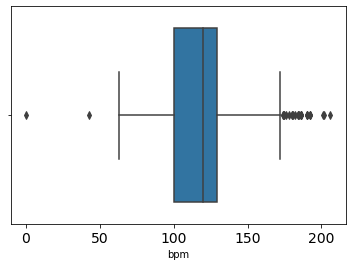

In [175]:
#Als letztes bezüglich der Bereinigung schauen wir nach Outliers. Hierfür benutze ich oft auch grafische Hilfsmittel

sns.boxplot(x=df_top_ten['bpm'])
boxplot_stats(df_top_ten['bpm'])

#Hier scheint es Ausreisser zu geben (Punkte, die grösser als die Whisker sind definiere ich hier als Outlier)

WHISLO: 63
WHISHI: 172


<AxesSubplot:xlabel='bpm'>

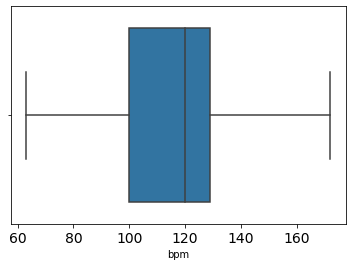

In [176]:
#Ob das nun statistisch/mathematisch korrekt ist oder nicht sei mal dahnigestellt (es geht hier um die Datenverarbeitung
#und die Anwendung von Python, Pandas etc., der Fokus soll darauf liegen zu zeigen, was ich gelernt habe bzw. kann).
#Die Outliers, die grösser sind als whishi (whisker high) werden mit dem whishi-Value überschriben, die Outliers
#die kleiner sind als whislo (whisker low) mit dem whislo-Value
#Dies wird mit dieser Funktion gemacht. Die Funktion nimmt das Attribut entgegen, welches bezüglich seinen
#Outliers bereinigt werden soll. Die Funktion mach auch Gebrauch von der boxplot_stats()_Funktion aus dem
#Matplotlib-Package.

def outlier_deletion(attribute):
    whislo = boxplot_stats(df_top_ten[attribute])[0]['whislo']
    whishi = boxplot_stats(df_top_ten[attribute])[0]['whishi']
    print("WHISLO:", whislo)
    print("WHISHI:", whishi)
    df_top_ten.loc[df_top_ten[str(attribute)] > whishi, str(attribute)] = whishi
    df_top_ten.loc[df_top_ten[str(attribute)] < whislo, str(attribute)] = whislo

outlier_deletion('bpm')

#Überprüfen wir das grafisch:
sns.boxplot(x=df_top_ten['bpm'])

#Sweet, nun haben wir keine Outliers mehr unter dem bpm-Attribut

WHISLO: 30
WHISHI: 98


<AxesSubplot:xlabel='nrgy'>

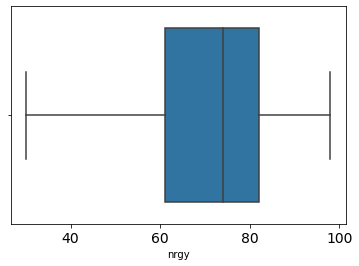

In [177]:
#Machen wir das auch noch bei den restlichen Attributen
outlier_deletion('nrgy')
sns.boxplot(x=df_top_ten['nrgy'])

WHISLO: 33
WHISHI: 97


<AxesSubplot:xlabel='dnce'>

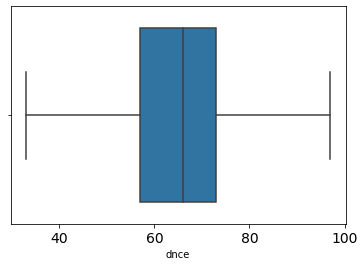

In [178]:
outlier_deletion('dnce')
sns.boxplot(x=df_top_ten['dnce'])

WHISLO: 0
WHISHI: 46


<AxesSubplot:xlabel='live'>

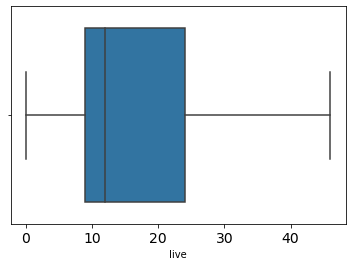

In [179]:
outlier_deletion('live')
sns.boxplot(x=df_top_ten['live'])

WHISLO: -9.0
WHISHI: -2.0


<AxesSubplot:xlabel='dB'>

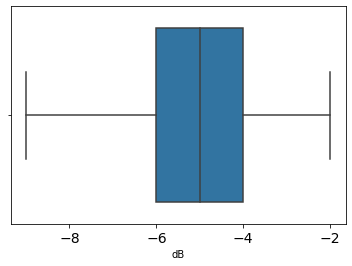

In [180]:
outlier_deletion('dB')
sns.boxplot(x=df_top_ten['dB'])

WHISLO: 0
WHISHI: 98


<AxesSubplot:xlabel='val'>

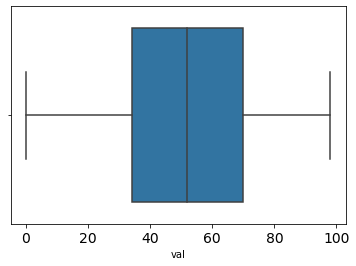

In [181]:
outlier_deletion('val')
sns.boxplot(x=df_top_ten['val'])

WHISLO: 148
WHISHI: 295


<AxesSubplot:xlabel='dur'>

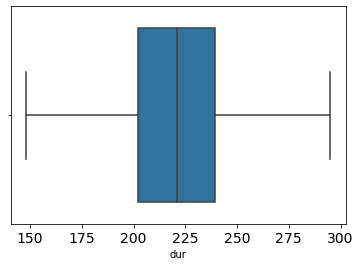

In [182]:
outlier_deletion('dur')
sns.boxplot(x=df_top_ten['dur'])

WHISLO: 0
WHISHI: 39


<AxesSubplot:xlabel='acous'>

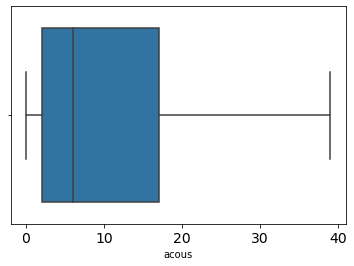

In [183]:
outlier_deletion('acous')
sns.boxplot(x=df_top_ten['acous'])

WHISLO: 0
WHISHI: 16


<AxesSubplot:xlabel='spch'>

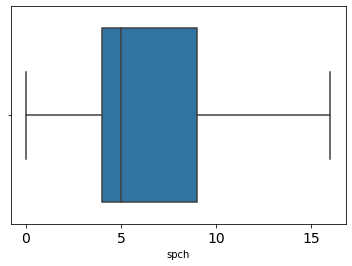

In [184]:
outlier_deletion('spch')
sns.boxplot(x=df_top_ten['spch'])

WHISLO: 36
WHISHI: 99


<AxesSubplot:xlabel='pop'>

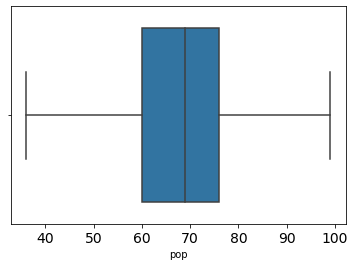

In [185]:
outlier_deletion('pop')
sns.boxplot(x=df_top_ten['pop'])

In [186]:
#Natürlich hätte man auch einfach wieder die Liste der Attribute einer Funktion übergeben können, dann wäre die Be-
#reinigung noch schneller gegangen. Ich wollte allerdings mit den boxplots überprüfen, ob sich die Outliers wirklich
#erübrigt haben. Das scheint auch der Fall zu sein.

Das dürfte nun der grösste Teil der Datenbereinigung gewesen sein. Es kann jedoch sein, dass einige Anpassung noch gemacht werden müssen, wenn die Analysen über alle 3 Datensets gemacht werden, um die definierten Fragen zu beantworten. Diese Modifikationen würden dann aber "on-the-fly" gemacht werden. Wir überprüfen nochmal das den ganzen DataFrame visuell.

In [187]:
pd.set_option("display.max_rows", 700)
df_top_ten

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,hip hop,2010,87,93,75,-5.0,46,64,263,24,16,82
2,TiK ToK,Kesha,pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,Baby,Justin Bieber,pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,Dynamite,Taio Cruz,pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,Secrets,OneRepublic,pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,pop,2010,93,37,48,-8.0,12,14,216,39,3,76
9,Only Girl (In The World),Rihanna,pop,2010,126,72,79,-4.0,7,61,235,13,4,73


Nun noch eine richtig mühsame Arbeit. Ich habe versucht, den Fehler auf OS- bzw. Applikationsebene zu beheben, habe aber keine Lösung gefunden. Die Special-Characters werden noch als � dargestellt. Das soll natürlich so nicht sein, ich fand aber trotz sehr, sehr, sehr langer Google-Suche keine Lösung das Problem zu beheben. Deshalb muss das nun händisch gemacht werden. Ausserdem muss die Richtigkeit bei jedem Problem sowieso einzeln überprüft werden, denn der Special-Character kann einer von vielen sein (', è, é, ...).

In [188]:
#Erst widmen wir uns den Titeln
df_top_ten[df_top_ten['title'].str.contains('�')]

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
70,Just Can�t Get Enough,The Black Eyed Peas,pop,2011,94,63,66,-9.0,11,26,219,19,16,71
132,We Are Young (feat. Janelle Mon�e),fun.,pop,2012,172,64,38,-6.0,8,74,251,2,8,63
192,Atlas - From �The Hunger Games: Catching Fire�...,Coldplay,permanent wave,2013,136,45,33,-8.0,11,11,236,39,3,55
258,Boom Clap - From the Motion Picture Das Schick...,Charli XCX,pop,2014,92,81,68,-4.0,34,64,169,7,6,50
388,Cold Water (feat. Justin Bieber & M�),Major Lazer,pop,2016,93,80,61,-5.0,16,50,185,7,4,73
422,Wish That You Were Here - From �Miss Peregrine...,Florence + The Machine,pop,2016,94,57,37,-6.0,13,12,295,39,3,57
457,I Don�t Wanna Live Forever (Fifty Shades Darker),ZAYN,pop,2017,118,45,74,-8.0,33,9,245,6,6,78
472,Reggaet�n Lento (Remix),CNCO,boy band,2017,94,91,53,-3.0,10,62,189,15,9,71
485,Bon app�tit,Katy Perry,pop,2017,106,79,80,-6.0,22,52,228,13,6,68
497,No Vacancy (with Sebasti�n Yatra),OneRepublic,pop,2017,100,76,69,-4.0,14,59,223,8,4,57


In [189]:
df_top_ten.loc[df_top_ten['title'].str.contains('Bon app�tit'), 'title'] = 'Bon appétit'
df_top_ten.loc[df_top_ten['title'].str.contains('Just Can�t Get Enough'), 'title'] = 'Just Can\'t Get Enough'
df_top_ten.loc[df_top_ten['title'].str.contains('Walk On Water \(feat. Beyonc�\)'), 'title'] = 'Walk On Water \(feat. Beyoncé\)'
df_top_ten.loc[df_top_ten['title'].str.contains('No Vacancy \(with Sebasti�n Yatra\)'), 'title'] = 'No Vacancy \(with Sebastián Yatra\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Se�orita'), 'title'] = 'Señorita'
df_top_ten.loc[df_top_ten['title'].str.contains('We Are Young \(feat. Janelle Mon�e\)'), 'title'] = 'e Are Young \(feat. Janelle Monáe\)'
df_top_ten.loc[df_top_ten['title'].str.contains('...Ready For It\? - BloodPop� Remix'), 'title'] = '...Ready For It\? - BloodPop® Remix'
df_top_ten.loc[df_top_ten['title'].str.contains('Friends \(with BloodPop�\)'), 'title'] = 'Friends \(with BloodPop®\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Wish That You Were Here - From �Miss Peregrine...'), 'title'] = 'Wish That You Were Here - From Miss Peregrine...'
df_top_ten.loc[df_top_ten['title'].str.contains('Perfect Duet \(Ed Sheeran & Beyonc�\)'), 'title'] = 'Perfect Duet \(Ed Sheeran & Beyoncé\)'
df_top_ten.loc[df_top_ten['title'].str.contains('I Don�t Wanna Live Forever \(Fifty Shades Darker\)'), 'title'] = 'I Don\'t Wanna Live Forever \(Fifty Shades Darker\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Mi Gente \(feat. Beyonc�\)'), 'title'] = 'Mi Gente \(feat. Beyoncé\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Boom Clap - From the Motion Picture Das Schicksal ist ein mieser Verr�ter'), 'title'] = 'Boom Clap - From the Motion Picture Das Schicksal ist ein mieser Verräter'
df_top_ten.loc[df_top_ten['title'].str.contains('Cold Water \(feat. Justin Bieber & M�\)'), 'title'] = 'Cold Water \(feat. Justin Bieber & MØ\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Atlas - From �The Hunger Games: Catching Fire� Soundtrack'), 'title'] = 'Atlas \(Hunger Games: Catching Fire\)'
df_top_ten.loc[df_top_ten['title'].str.contains('Reggaet�n Lento \(Remix\)'), 'title'] = 'Reggaetón Lento \(Remix\)'


df_top_ten[df_top_ten['title'].str.contains('�')] #Wenn kein Output generiert wird sind wir zufrieden

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop


In [190]:
#Dann noch den Artisten
df_top_ten[df_top_ten['artist'].str.contains('�')]

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
56,Run the World (Girls),Beyonc�,pop,2011,127,90,73,-4.0,37,76,236,0,14,76
58,Love On Top,Beyonc�,pop,2011,94,75,65,-5.0,46,65,267,8,9,76
65,Best Thing I Never Had,Beyonc�,pop,2011,99,65,55,-4.0,9,30,254,14,3,73
87,1+1,Beyonc�,pop,2011,63,38,33,-7.0,7,26,274,38,3,60
184,Next To Me,Emeli Sand�,pop,2013,95,80,67,-5.0,11,35,197,9,4,60
186,Clown,Emeli Sand�,pop,2013,130,30,45,-8.0,11,23,221,39,4,60
241,Partition,Beyonc�,pop,2014,172,44,41,-9.0,31,17,295,3,16,65
253,XO,Beyonc�,pop,2014,170,79,47,-9.0,31,21,216,17,16,56
256,Drunk in Love,Beyonc�,pop,2014,140,62,59,-7.0,18,40,295,1,5,52
297,43776,Beyonc�,pop,2015,136,71,75,-5.0,13,56,214,1,13,72


In [191]:
df_top_ten.loc[df_top_ten['artist'].str.contains('Beyonc�'), 'artist'] = 'Beyoncé'
df_top_ten.loc[df_top_ten['artist'].str.contains('Emeli Sand�'), 'artist'] = 'Emeli Sandé'
df_top_ten.loc[df_top_ten['artist'].str.contains('B�RNS'), 'artist'] = 'BøRNS'
df_top_ten.loc[df_top_ten['artist'].str.contains('M�'), 'artist'] = 'Mø'

df_top_ten[df_top_ten['artist'].str.contains('�')] #Wenn kein Output generiert wird sind wir zufrieden

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop


In [192]:
#Nochmal einen Blick auf das Datenset werfen
pd.set_option("display.max_rows", 700)
df_top_ten

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,hip hop,2010,87,93,75,-5.0,46,64,263,24,16,82
2,TiK ToK,Kesha,pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,Baby,Justin Bieber,pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,Dynamite,Taio Cruz,pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,Secrets,OneRepublic,pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,pop,2010,93,37,48,-8.0,12,14,216,39,3,76
9,Only Girl (In The World),Rihanna,pop,2010,126,72,79,-4.0,7,61,235,13,4,73


In [193]:
#Das Datenset sieht so ganz in Ordnung aus. Die Special Characters bereiten mir noch etwas Sorgen, aber wir werden
#sehen, wie wir damit umgehen werden. Das Datenset wird nun so als "stage"-Version gespeichert.

df_top_ten.to_csv('Workingdata/top_ten_stage.csv', index = False)

## Datenanalyse Kaggle-Datenset

Da ich zum Zeitpunkt der Erstellung diese Notebooks lediglich das von Kaggle heruntergeladene Datenset zur Verfügung habe (Student A und B sind noch am Scrapen), werde ich dieses Datenset mal etwas analysieren. Es gilt hier zu erwähnen, dass ich keine grosse Ahnung von Musik habe, es mich aber interessiert, ob sich die Musik in den letzten 9 Jahren verändert hat (z.B. im Hinblick auf die Geschwindigkeit). Das Datenset ist natürlich nicht repräsentativ oder aussagekräftig, da es lediglich die Top-10 der Jahre 2010 - 2019 sind. Es geht hier vor allem darum, Seaborn und Matplotlib anzuwenden und etwas herumzuspielen um zu lernen.

In [194]:
#CSV laden
df = pd.read_csv('Workingdata/top_ten_stage.csv')
df

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,hip hop,2010,87,93,75,-5.0,46,64,263,24,16,82
2,TiK ToK,Kesha,pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,Baby,Justin Bieber,pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,Dynamite,Taio Cruz,pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,Secrets,OneRepublic,pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,pop,2010,93,37,48,-8.0,12,14,216,39,3,76
9,Only Girl (In The World),Rihanna,pop,2010,126,72,79,-4.0,7,61,235,13,4,73


Mal schauen, welche Artists am meisten vorkommen:

/home/student/venv/pds01-jpy-3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


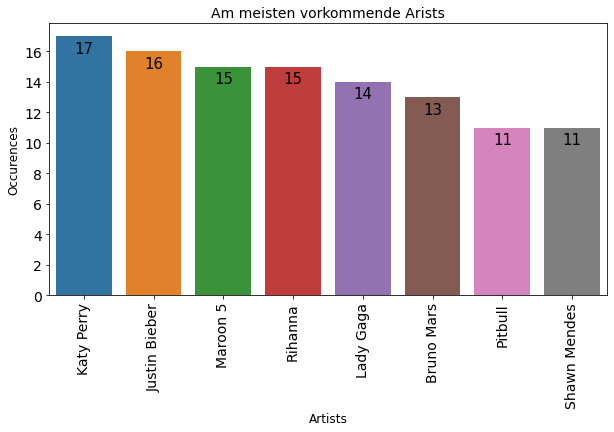

In [195]:
artist_counts = df['artist'].value_counts()
artist_counts = artist_counts[:8,]
plt.figure(figsize=(10,5))
x = artist_counts.index
y = artist_counts.values
splot = sns.barplot(x, y)

#Damit auch die Zahlen als Labels on Top der Bars angezeigt erden
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')


plt.title('Am meisten vorkommende Arists')
plt.ylabel('Occurences', fontsize=12)
plt.xlabel('Artists', fontsize=12)
plt.xticks(rotation=90)
plt.show()

del x
del y
del splot

Wir können das nun auch noch mit dem Genre machen. Welche Genres kommen am häufigsten vor?

/home/student/venv/pds01-jpy-3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


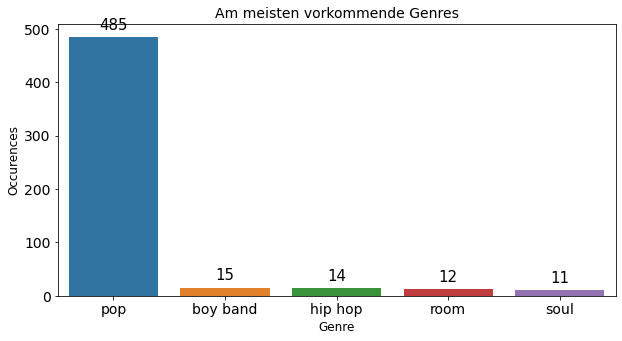

In [196]:
genre_counts = df['genre'].value_counts()
genre_counts = genre_counts[:5,]
plt.figure(figsize=(10,5))
x = genre_counts.index
y = genre_counts.values
splot = sns.barplot(x, y)

#Damit auch die Zahlen als Labels on Top der Bars angezeigt erden
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, +12), 
                   textcoords = 'offset points')


plt.title('Am meisten vorkommende Genres', fontsize = 14)
plt.ylabel('Occurences', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

del x
del y
del splot

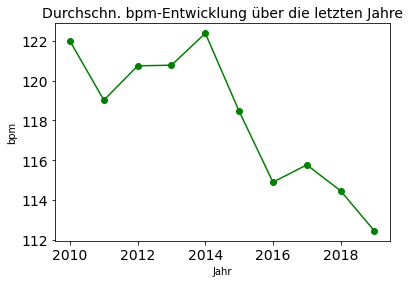

In [197]:
grouped_by_year_mean = df.groupby(['year']).mean()

y = grouped_by_year_mean['bpm']
x = grouped_by_year_mean.index.to_list()

plt.plot(x, y, color='green', marker='o')
plt.title('Durchschn. bpm-Entwicklung über die letzten Jahre', fontsize = 14)
plt.xlabel('Jahr')
plt.ylabel('bpm')
plt.show()

So wie es scheint, ist beliebte Musik langsamer geworden über die letzten Jahre.

Wir können nun auch noch nach linearen Korrelationen suchen (optisch und mit Hilfe von R²). Nachfolgend mache ich das, wobei nur ein paar von allen möglichen Korrelationen getestet werden. Steht kein Kommentar ist keine Korrelation ersichtlich.

R^2 is:  0.020839625000363248


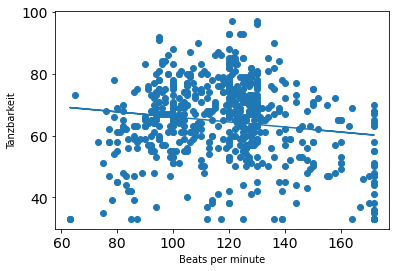

In [198]:
x = df['bpm']
y = df['dnce']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Beats per minute")
plt.ylabel("Tanzbarkeit")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

del x
del y
del m
del b
del r_value

R^2 is:  0.014476428343391655


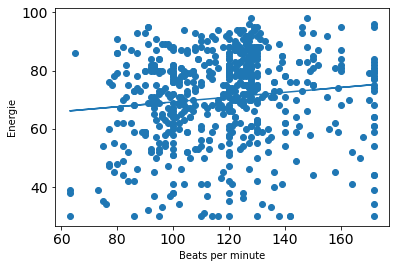

In [199]:
x = df['bpm']
y = df['nrgy']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Beats per minute")
plt.ylabel("Energie")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

del x
del y
del m
del b
del r_value

R^2 is:  0.023312486162236797


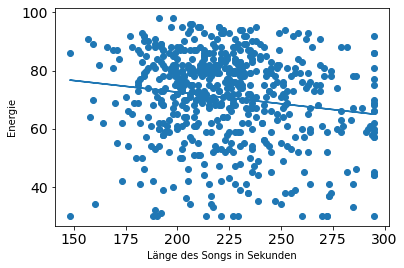

In [200]:
x = df['dur']
y = df['nrgy']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Länge des Songs in Sekunden")
plt.ylabel("Energie")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

del x
del y
del m
del b
del r_value

R^2 is:  0.004076663889591137


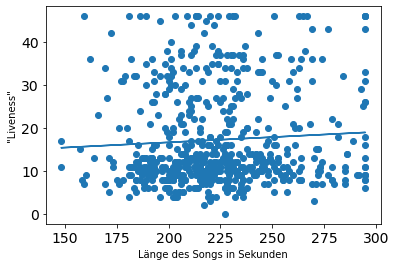

In [201]:
x = df['dur']
y = df['live']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Länge des Songs in Sekunden")
plt.ylabel("\"Liveness\"")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

del x
del y
del m
del b
del r_value

Bisher habe ich keine lineare Korrelation gefunden. Für dieses Datenset gäbe es 91 mögliche Pärchen/Kombinationen, um lineare Korrelationen zu finden:

$\frac{n!}{r!(n-r)!}$

wobei n die Anzahl Objekte (14) und r die Anzahl Objekte, welche ausgewählt werden (2) ist.

Dies wären zu viele Kombinationen um manuell zu überprüfen, ob es eine lineare Korrelation gibt zwischen irgendwelchen Attributs-Paaren. Deshalb wird das nun "automatisiert". Für dieses vergleichsweise kleine Datenset ist dies möglich, für grössere könnte dies zu Problemen führen. Hierzu kann das pingouin-Package genutzt werden. Es berücksichtigt keine Attribute vom Type "object". Die möglichen Kombinationen verringern sich deshalb auf 55.

In [202]:
df_corr = pg.pairwise_corr(df)
df_corr.sort_values(['r2'], ascending = False)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
20,nrgy,dB,pearson,two-sided,603,0.643402,"[0.59, 0.69]",4.139666e-01,0.412013,0.763958,9.193679e-72,1.646e+68,1.000000
29,dnce,val,pearson,two-sided,603,0.469239,"[0.4, 0.53]",2.201848e-01,0.217585,0.509093,2.409415e-34,1.14e+31,1.000000
24,nrgy,acous,pearson,two-sided,603,-0.458793,"[-0.52, -0.39]",2.104912e-01,0.207859,-0.495782,1.008836e-32,2.818e+29,1.000000
22,nrgy,val,pearson,two-sided,603,0.382788,"[0.31, 0.45]",1.465268e-01,0.143682,0.403323,1.769371e-22,2.074e+19,1.000000
35,dB,val,pearson,two-sided,603,0.331626,"[0.26, 0.4]",1.099756e-01,0.107009,0.344654,6.043712e-17,7.281e+13,1.000000
9,year,pop,pearson,two-sided,603,0.252670,"[0.18, 0.33]",6.384237e-02,0.060722,0.258263,3.091363e-10,1.945e+07,0.999994
37,dB,acous,pearson,two-sided,603,-0.247474,"[-0.32, -0.17]",6.124356e-02,0.058114,-0.252721,7.253247e-10,8.478e+06,0.999989
1,year,nrgy,pearson,two-sided,603,-0.231658,"[-0.31, -0.15]",5.366557e-02,0.050511,-0.235941,8.649745e-09,7.63e+05,0.999934
45,val,dur,pearson,two-sided,603,-0.228979,"[-0.3, -0.15]",5.243137e-02,0.049273,-0.233112,1.293810e-08,5.164e+05,0.999913
6,year,dur,pearson,two-sided,603,-0.226404,"[-0.3, -0.15]",5.125876e-02,0.048096,-0.230396,1.896299e-08,3.566e+05,0.999887


Die Attribute nrgy und dB haben den höchsten R²-Value. Ob das in diesem Bereich viel ist oder nicht lassen wir Experten entscheiden. Aber wir plotten diese Grafik mal.

R^2 is:  0.41396663706940406


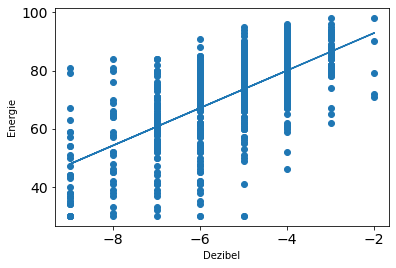

In [203]:
x = df['dB']
y = df['nrgy']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Dezibel")
plt.ylabel("Energie")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

del x
del y
del m
del b
del r_value

Man hätte dies natürlich auch mit Pandas machen können. Allerdings hat dies den Nachteil, dass Pandas nur den R-Wert und nicht R² liefert. Zudem lässt sich bei der Analyse mit der Funktion aus dem Pingouin-Package gleich nach dem gesuchten Wert sortieren (absteigend/aufsteigend). Ein grosser Vorteil ist, dass die Pingouin-Funktion mehrere Werte (beispielsweise auch gleich noch den adjusted R²) ausgibt. Möchte man R² via Pandas erfragen geht das folgendermassen:

In [204]:
df.corr(method = 'pearson') * df.corr(method = 'pearson')

,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
year,1.000000,1.284451e-02,0.053666,0.006761,3.810046e-02,0.018916,1.561363e-02,0.051259,0.017506,8.632441e-04,0.063842
bpm,0.012845,1.000000e+00,0.014476,0.020840,4.019468e-03,0.007351,6.945089e-07,0.000454,0.018755,6.023955e-03,0.000010
nrgy,0.053666,1.447643e-02,1.000000,0.016356,4.139666e-01,0.037483,1.465268e-01,0.023312,0.210491,2.990356e-02,0.010138
dnce,0.006761,2.083963e-02,0.016356,1.000000,1.280860e-02,0.001743,2.201848e-01,0.031213,0.032063,2.680296e-03,0.010673
dB,0.038100,4.019468e-03,0.413967,0.012809,1.000000e+00,0.004340,1.099756e-01,0.021706,0.061244,2.833220e-07,0.000017
live,0.018916,7.351474e-03,0.037483,0.001743,4.340128e-03,1.000000,7.105946e-04,0.004077,0.011284,3.547572e-02,0.007582
val,0.015614,6.945089e-07,0.146527,0.220185,1.099756e-01,0.000711,1.000000e+00,0.052431,0.041601,2.786190e-02,0.001189
dur,0.051259,4.538693e-04,0.023312,0.031213,2.170619e-02,0.004077,5.243137e-02,1.000000,0.009625,5.659511e-05,0.011840
acous,0.017506,1.875507e-02,0.210491,0.032063,6.124356e-02,0.011284,4.160068e-02,0.009625,1.000000,3.023576e-03,0.002729
spch,0.000863,6.023955e-03,0.029904,0.002680,2.833220e-07,0.035476,2.786190e-02,0.000057,0.003024,1.000000e+00,0.000084


/home/student/venv/pds01-jpy-3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'bpm'}>,
        <AxesSubplot:title={'center':'nrgy'}>],
       [<AxesSubplot:title={'center':'dnce'}>,
        <AxesSubplot:title={'center':'dB'}>,
        <AxesSubplot:title={'center':'live'}>],
       [<AxesSubplot:title={'center':'val'}>,
        <AxesSubplot:title={'center':'dur'}>,
        <AxesSubplot:title={'center':'acous'}>],
       [<AxesSubplot:title={'center':'spch'}>,
        <AxesSubplot:title={'center':'pop'}>, <AxesSubplot:>]],
      dtype=object)

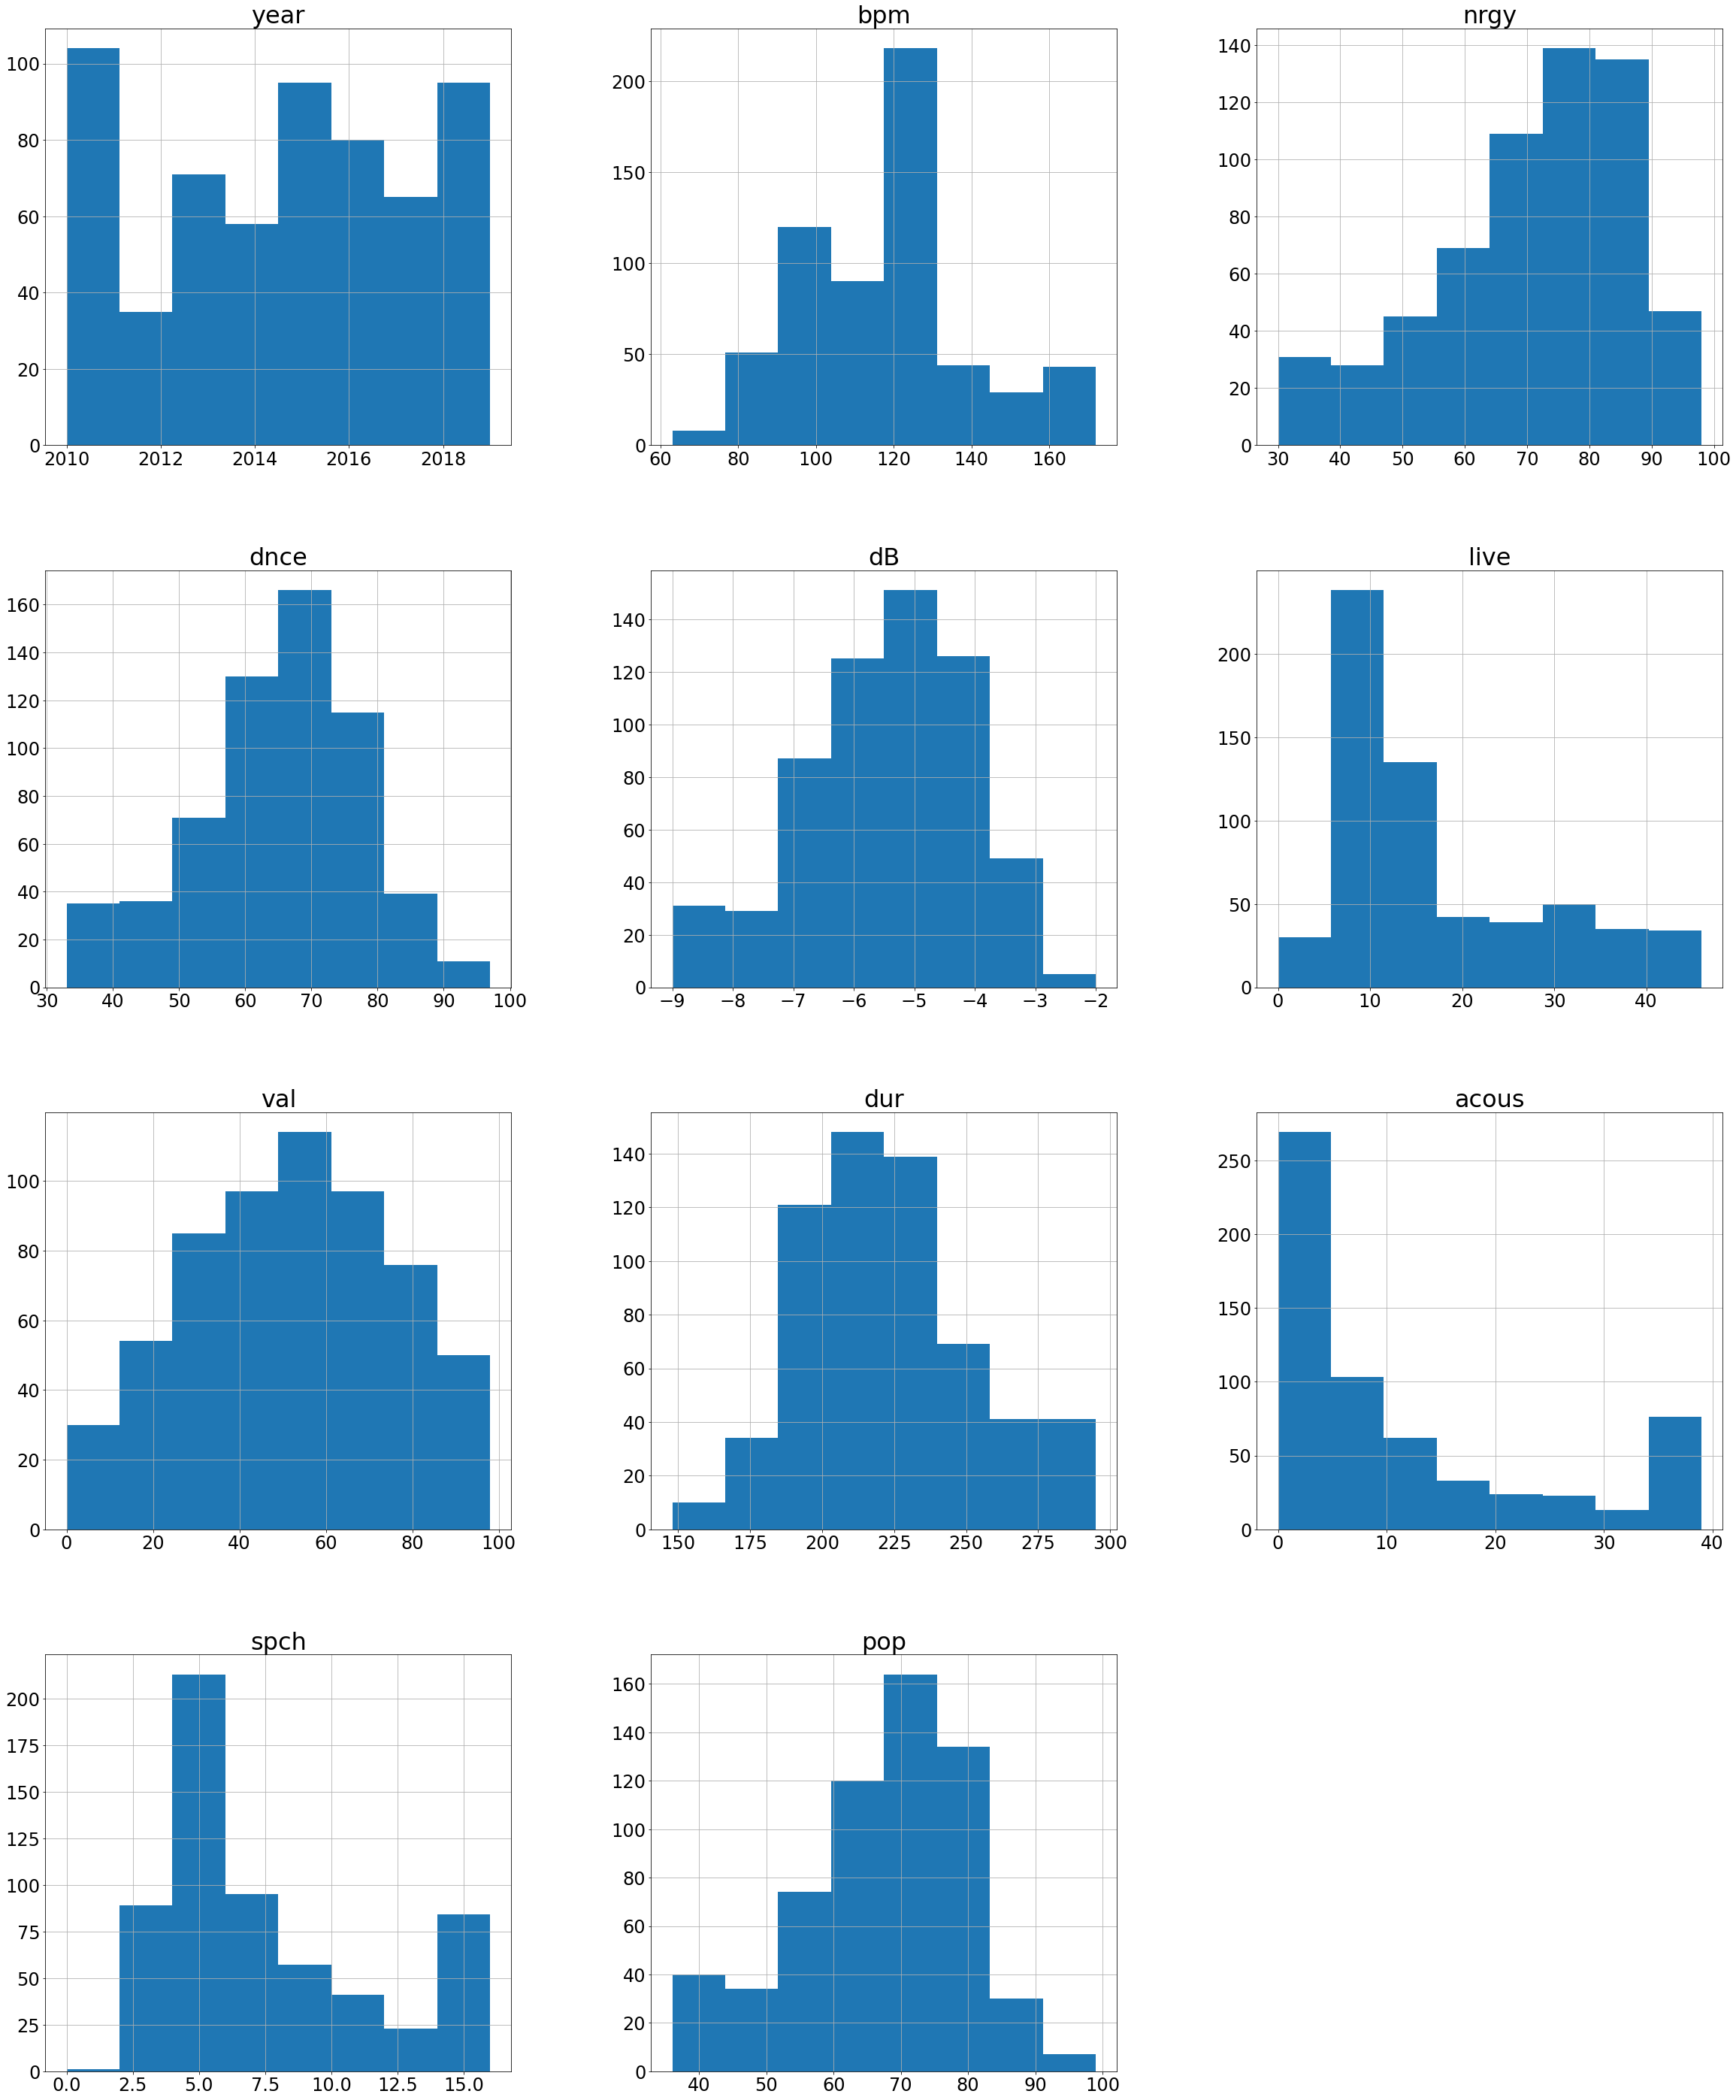

In [205]:
#Mit der hist()-Funktion können wir auch die Verteilung der Daten in den versch. Attributen anschauen.
#Natürlich lässt sich mit den Bins etc. noch rumspielen.

#Diese 2 Schritte müssen wir durchführen, sonst werden der Titel, die X- und Y-Achsenbeschriftung extrem klein
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
matplotlib.rcParams.update(params)

#Dann das Histogram erstellen
df.hist(bins = 8, figsize= (40, 50))

In [206]:
#Wir setzen das jetzt wieder zurück
params = {'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)

## DB-Connection
Während ich auf die gescrapten Daten warte werde ich noch den Datenbankimport erledigen (zumindest von meinem Datenset).
Im folgenden Abschnitt wird die Verbindung zu MariaDB aufgebaut, die DB und der Table erstellt und die Daten eingefüllt. Hier möchte ich erwähnen, dass ich die Parallelvorlesung "Database-Management" nicht besuche, da ich diese aus dem Bachelor anrechnen lassen konnte. Sollte ich deshalb etwas nicht "wie gewünscht" gemacht haben könnte es daran liegen, dass ich es mal anders gelernt habe bzw. die DB-Management-Voresung nicht an der HSLU besucht habe.

In [235]:
#Verbindung aufbauen
#PW in Plain-Text ist natürlich nicht optimal... aber irgendwo hätte ich es sowieso aufschreiben müssen, deshalb
#habe ich darauf verzichtet, das PW zu hashen
try:
    conn = mariadb.connect(
      user="admin",
      password="tobi22!",
      host="localhost",
      port=3306,
      autocommit=True) #So erübrigt sich conn.commit()        
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

print("Verbindung erfolgreich aufgebaut.")


Verbindung erfolgreich aufgebaut.


In [236]:
#Cursor kreieren, über welchen die DB erreicht wird.
cur = conn.cursor()

In [237]:
#Nun können wir via Cursor SQL-Queries schreiben. Hier erstellen wir die Datenbank. Die SQL-Queries sollten
#selbsterklärend sein.
database_name = "CIP"

cur.execute("DROP DATABASE IF EXISTS " + database_name + ";") 
cur.execute("CREATE DATABASE " + database_name + ";")
cur.execute("USE " + database_name + ";")

In [238]:
db_table_name = "top_ten_spotify_kaggle"
csv_file_name_path = "Workingdata/top_ten_stage.csv"
field_terminator = ","
line_terminator = "\n"
lines_to_be_igored = "1" #so wird die 1. Line (Column-Names) ignoriert

In [239]:
#Table in der DB erstellen mit den entsprechenden Attributen
cur.execute("CREATE TABLE IF NOT EXISTS " + db_table_name + \
            "("
            "artist varchar(255),"
            "title varchar(255),"
            "year INTEGER,"
            "bpm DECIMAL,"
            "nrgy DECIMAL,"
            "dnce DECIMAL,"
            "dB DECIMAL,"
            "live DECIMAL,"
            "val DECIMAL,"
            "dur DECIMAL,"
            "acous DECIMAL,"
            "spch DECIMAL,"
            "pop DECIMAL" 
            ");"
            )

In [240]:
#Query zum Einlesen der Daten
query_insert = "LOAD DATA LOCAL INFILE '" + csv_file_name_path + \
                "' INTO TABLE " + db_table_name + \
                " FIELDS TERMINATED BY '" + field_terminator + \
                "' LINES TERMINATED BY '" + line_terminator + \
                "' IGNORE " + lines_to_be_igored + " LINES;"

#Ausführung des Queries bzw. tatsächlicher Import der Daten
cur.execute(query_insert)


In [213]:
#Üblicherweise würden wir hier noch die Connection schliessen, machen wir aber in unserem Fall nicht
#(aus Gründen der Bequemlichkeit, ansonsten müssten wir die Connection immer wieder aufbauen, zum Testen ist das nervig):
#conn.close()

## Zusammenführung Datensets/Beantwortung der definierten Fragen

In folgendem Abschnitt werden die im ETL-Prozess definierten Fragen beantwortet.

Erst die Datensets von den übrigen Gruppenmitgliedern laden:

An dieser Stelle möchte ich erwähnen, dass in meinen Augen die "Sauberkeit" der Datensets Eigenverantwortung von Student A und B sind.

In [214]:
df_grammy = pd.read_csv('Workingdata/Suter_Sandro_stage.csv')
df_youtube = pd.read_csv('Workingdata/Lars_Hubacher_stage.csv', index_col = 0)
df_spotify = pd.read_csv('Workingdata/top_ten_stage.csv') #auch dieses lade ich der Vollständigkeit wegen nochmal 

Mal die Datensets anschauen:

In [215]:
df_grammy

,Kategorie,Jahr,Winner,Künstler/in,artist2,_Künstler/in umfassend
0,Record Of The Year,2020,Everything I Wanted,Billie Eilish,",No Interpreten,",Billie Eilish
1,Record Of The Year,2019,Bad Guy,Billie Eilish,",No Interpreten,",Billie Eilish
2,Record Of The Year,2018,This Is America,Childish Gambino,",No Interpreten,",Childish Gambino
3,Record Of The Year,2017,24K Magic,Bruno Mars,",No Interpreten,",Bruno Mars
4,Record Of The Year,2016,Hello,Adele,",No Interpreten,",Adele
5,Record Of The Year,2015,Uptown Funk,Mark Ronson Featuring Bruno Mars,",No Interpreten,",Mark Ronson Featuring Bruno Mars
6,Record Of The Year,2014,Stay With Me (Darkchild Version),Sam Smith,",No Interpreten,",Sam Smith
7,Record Of The Year,2013,Get Lucky,Daft Punk Featuring Pharrell Williams & Nile R...,",No Interpreten,",Daft Punk Featuring Pharrell Williams & Nile R...
8,Record Of The Year,2012,Somebody That I Used To Know,Gotye Featuring Kimbra,",No Interpreten,",Gotye Featuring Kimbra
9,Record Of The Year,2011,Rolling In The Deep,Adele,",No Interpreten,",Adele


In [216]:
df_youtube

,Künstler/in,Song,Director,Views auf Youtube in Mio.
0,Luis Fonsi,Despacito,Carlos Pérez,7300.0
1,Ed Sheeran,Shape Of You,Jason Koenig,5300.0
2,Wiz Khalifa,See You Again,Marc Klasfeld,5100.0
3,Mark Ronson,Uptown Funk,Cameron Duddy,4200.0
4,Psy,Gangnam Style,Cho Soo-hyun,4100.0
5,Maroon 5,Sugar,David Dobkin,3500.0
6,Katy Perry,Roar,"Grady Hall, Mark Kudsi",3300.0
7,OneRepublic,Counting Stars,James Lees,3300.0
8,Ed Sheeran,Thinking Out Loud,Emil Nava,3200.0
9,Katy Perry,Dark Horse,Mathew Cullen,3100.0


In [217]:
df_spotify

,title,artist,genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4.0,8,80,217,19,4,83
1,Love The Way You Lie,Eminem,hip hop,2010,87,93,75,-5.0,46,64,263,24,16,82
2,TiK ToK,Kesha,pop,2010,120,84,76,-3.0,29,71,200,10,14,80
3,Bad Romance,Lady Gaga,pop,2010,119,92,70,-4.0,8,71,295,0,4,79
4,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5.0,9,43,221,2,4,78
5,Baby,Justin Bieber,pop,2010,65,86,73,-5.0,11,54,214,4,14,77
6,Dynamite,Taio Cruz,pop,2010,120,78,75,-4.0,4,82,203,0,9,77
7,Secrets,OneRepublic,pop,2010,148,76,52,-6.0,12,0,225,7,4,77
8,Empire State of Mind (Part II) Broken Down,Alicia Keys,pop,2010,93,37,48,-8.0,12,14,216,39,3,76
9,Only Girl (In The World),Rihanna,pop,2010,126,72,79,-4.0,7,61,235,13,4,73


In [218]:
df_grammy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Kategorie               118 non-null    object
 1   Jahr                    118 non-null    int64 
 2   Winner                  118 non-null    object
 3   Künstler/in             118 non-null    object
 4   artist2                 118 non-null    object
 5   _Künstler/in umfassend  97 non-null     object
dtypes: int64(1), object(5)
memory usage: 5.7+ KB


In [219]:
df_youtube.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 0 to 279
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Künstler/in                280 non-null    object 
 1   Song                       280 non-null    object 
 2   Director                   280 non-null    object 
 3   Views auf Youtube in Mio.  280 non-null    float64
dtypes: float64(1), object(3)
memory usage: 10.9+ KB


In [220]:
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   603 non-null    object 
 1   artist  603 non-null    object 
 2   genre   603 non-null    object 
 3   year    603 non-null    int64  
 4   bpm     603 non-null    int64  
 5   nrgy    603 non-null    int64  
 6   dnce    603 non-null    int64  
 7   dB      603 non-null    float64
 8   live    603 non-null    int64  
 9   val     603 non-null    int64  
 10  dur     603 non-null    int64  
 11  acous   603 non-null    int64  
 12  spch    603 non-null    int64  
 13  pop     603 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 66.1+ KB


### Zeigt sich der Erfolg (Clicks, Views etc.) bei den digitalen Medien auch bei den Gewinnern/innen der Hauptkategorien der Grammy Awards?

Diese Frage ist relativ schwierig zu beantworten, aus dem Grund, dass die Definition von "Erfolg" subjektiv sein mag. Ich denke aber, dass es in diesem Kontext sinnvoll ist, Erfolg mit der Anzahl Klicks und den gewonnenen Preisen zu definieren. Nun stellt sich die Frage, wie wir das messen wollen
Ich denke, hier kann man in Interpreten und Songs unterteilen. Ich wede schauen, welche Interpreten im Total die meisten Klicks bei Youtube haben. Dann werde ich vergleichen, wie viele Preise diese Interpreten in den Hauptkategorien der Grammys gewonnen haben. Die Interpretation von "Erfolg" lässt dann am Ende doch wieder viel Intepretationsspielraum zu.

In [221]:
#Schauen wir mal, welche 5 Künstler die meisten Klicks bei Youtube hatten:
df_top_5_youtube = df_youtube.groupby('Künstler/in').sum().sort_values(by=['Views auf Youtube in Mio.'], ascending = False).iloc[0:5]
df_top_5_youtube

,Views auf Youtube in Mio.
Künstler/in,
Katy Perry,13760.2
Ed Sheeran,12400.0
Taylor Swift,9600.0
Luis Fonsi,9400.0
Bruno Mars,9000.0


In [222]:
df_grammy_per_artist = df_grammy['Künstler/in'].value_counts().to_frame().reset_index() #to_frame(), weil es sonst eine Series und kein DF ist
df_grammy_per_artist.columns = ['Künstler/in', 'Grammys won']
df_grammy_per_artist.head(15)

#Es gibt hier offenbar viele "No Interpreten". Das mag damit zusammenhängen, dass viele der Gewinner auch Produzenten
#etc. sind. Wir fokussieren uns hier aber nur auf Künstler, die man auch kennt, also Interpreten.

,Künstler/in,Grammys won
0,",No Interpreten,",42
1,Adele,5
2,U2,4
3,Billie Eilish,3
4,Taylor Swift,3
5,Various Artists,3
6,Foo Fighters,2
7,Childish Gambino,2
8,Dixie Chicks,2
9,Bruno Mars,2


In [223]:
#Nun mergen wir die obigen DF's (ich nutze immer ".merge()", join mochte ich nie)
df_grammys_top_5_youtube = df_grammy_per_artist.merge(df_top_5_youtube, on = 'Künstler/in', how = 'right')
df_grammys_top_5_youtube.to_excel('Workingdata/Result_Question_01.1.xlsx', index = False)
#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_01.1.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_01.1.xlsx
df_grammys_top_5_youtube

,Künstler/in,Grammys won,Views auf Youtube in Mio.
0,Katy Perry,NaN,13760.2
1,Ed Sheeran,NaN,12400.0
2,Taylor Swift,3.0,9600.0
3,Luis Fonsi,NaN,9400.0
4,Bruno Mars,2.0,9000.0


Nun sind wir bei der vorher erwähnten, eher subjektiven Einschätzung. Nur 2 der 5 Interpreten mit den total meisten Klicks bei Youtube haben einen Grammy gewonnen (beide dafür mehrfach). Für mich ein Indiz dafür, dass viele Klicks bei Youtube keinen Grammy garantieren.

Wir können das auch noch bei den Spotify-Interpreten untersuchen. Hier müssen wir jedoch schauen, wie oft ein Interpret in der Liste vorkommt. Wir haben keine Zahlen bezüglich wie oft ein Song gestreamt wurde. Wir nehmen wieder die Top 5.

In [224]:
df_top_5_spotify = df_spotify['artist'].value_counts().to_frame().reset_index().iloc[0:5]
df_top_5_spotify.columns = ['artist', 'occurences']
df_top_5_spotify

,artist,occurences
0,Katy Perry,17
1,Justin Bieber,16
2,Maroon 5,15
3,Rihanna,15
4,Lady Gaga,14


In [225]:
#Wir mergen auch diese DFs, vorher benennen wir noch die Column um, welche wir mergen, das vereinfacht den merge
df_grammy_per_artist.rename(columns = {'Künstler/in':'artist'}, inplace = True)
df_grammys_top_5_spotify = df_grammy_per_artist.merge(df_top_5_spotify, on = 'artist', how = 'right')
df_grammys_top_5_spotify.to_excel('Workingdata/Result_Question_01.2.xlsx', index = False)
#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_01.2.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_01.2.xlsx
df_grammys_top_5_spotify

,artist,Grammys won,occurences
0,Katy Perry,NaN,17
1,Justin Bieber,NaN,16
2,Maroon 5,NaN,15
3,Rihanna,NaN,15
4,Lady Gaga,1.0,14


Hier sieht es also noch schlimmer aus als bei den Youtube-Views. Die 5 Künstler, die am meisten im Spotify-Top-10 per Year Dataset vorkommen haben gesamthaft nur 1 Grammy gewonnen. Die Anzahl Streams scheint keinen Einfluss auf einen Grammy-Erfolg zu haben. 

### Hat die Songdauer einen Einfluss auf die Views auf Youtube?
Herfür wird die corr()-Funktion von Pandas verwendet. Vorher wird ein Dataframe erstellt mit allen Songs, die in im df_youtube und im df_spotify vorkommen.

In [226]:
df_spotify_youtube = df_spotify.merge(df_youtube, left_on = 'title', right_on = 'Song')

In [227]:
df_spotify_youtube.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title                      83 non-null     object 
 1   artist                     83 non-null     object 
 2   genre                      83 non-null     object 
 3   year                       83 non-null     int64  
 4   bpm                        83 non-null     int64  
 5   nrgy                       83 non-null     int64  
 6   dnce                       83 non-null     int64  
 7   dB                         83 non-null     float64
 8   live                       83 non-null     int64  
 9   val                        83 non-null     int64  
 10  dur                        83 non-null     int64  
 11  acous                      83 non-null     int64  
 12  spch                       83 non-null     int64  
 13  pop                        83 non-null     int64  
 

Es gibt also 84 Übereinstimmungen. Nun droppen wir noch unnötige Columns: "Künstler/in", Song und benennen die Column "Views auf Youtube in Mio.

In [228]:
df_spotify_youtube.drop(['Künstler/in', 'Song'], inplace = True, axis = 1)
df_spotify_youtube.rename(columns = {'Views auf Youtube in Mio.':'Views'}, inplace = True)
df_spotify_youtube.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     83 non-null     object 
 1   artist    83 non-null     object 
 2   genre     83 non-null     object 
 3   year      83 non-null     int64  
 4   bpm       83 non-null     int64  
 5   nrgy      83 non-null     int64  
 6   dnce      83 non-null     int64  
 7   dB        83 non-null     float64
 8   live      83 non-null     int64  
 9   val       83 non-null     int64  
 10  dur       83 non-null     int64  
 11  acous     83 non-null     int64  
 12  spch      83 non-null     int64  
 13  pop       83 non-null     int64  
 14  Director  83 non-null     object 
 15  Views     83 non-null     float64
dtypes: float64(2), int64(10), object(4)
memory usage: 11.0+ KB


Wir wollen nun prüfen, ob es einen Zusammenhang mit der Anzahl Views und der Songlänge gibt.

R^2 is:  0.01810457073724113


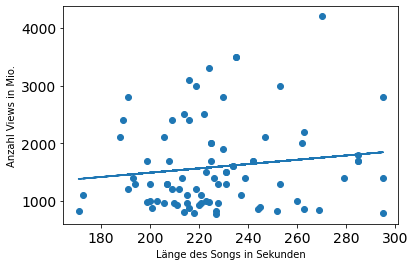

In [229]:
x = df_spotify_youtube['dur']
y = df_spotify_youtube['Views']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
m, b = np.polyfit(x, y, 1)

plt.xlabel("Länge des Songs in Sekunden")
plt.ylabel("Anzahl Views in Mio.")

plt.plot(x, m*x + b)
plt.scatter(x, y)

print("R^2 is: ", r_value * r_value)

#Weil vermutlich gewünscht hier noch der Export der Grafik in ein Excel (das habe ich "ergoogelt")
plt.savefig('Workingdata/plot_2.png')
workbook = xlsxwriter.Workbook('Workingdata/Result_Question_02_plot.xlsx')
worksheet = workbook.add_worksheet()
worksheet.insert_image('A1', 'Workingdata/plot_2.png')
workbook.close()


del x
del y
del m
del b
del r_value

#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_02_plot.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_02_plot.xlsx
!rm Workingdata/plot_2.png

In [230]:
df_spotify_youtube

df_spotify_youtube.to_excel('Workingdata/Result_Question_02_table.xlsx', index = False)

#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_02_table.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_02_table.xlsx

Ein Blick auf die Grafik lässt schon erahnen, dass es keinen (linearen) Zusammenhang gibt. Dies wird vom eher niedrigen R²-Wert auch bestätigt. Wir können die Frage also so beantworten: Nein, es scheint keinen Zusammenhang zwischen der Songaduer und der Anzahl Views zu geben - zumindest für die Songs, die deren Daten wir zur Verfügung haben.

### Wie haben sich die Songattribute "Beats per Minute" und "Duration" der erfolgreichen Songs auf Spotify seit 2010 verändert?
Dies Frage wurde zu einem Teil schon weiter oben bei der Analyse des Kaggle-Datasets beantwortet. Trotzdem, wir werden noch weitergehen. Hier nun nochmal die entsprechenden Grafiken:

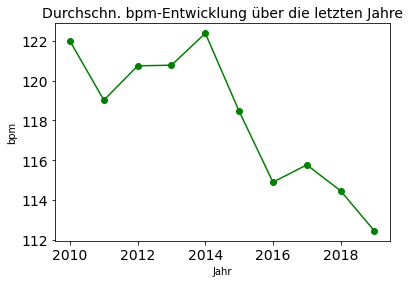

In [231]:
grouped_by_year_mean = df_spotify.groupby(['year']).mean()

y = grouped_by_year_mean['bpm']
x = grouped_by_year_mean.index.to_list()

plt.plot(x, y, color='green', marker='o')
plt.title('Durchschn. bpm-Entwicklung über die letzten Jahre', fontsize = 14)
plt.xlabel('Jahr')
plt.ylabel('bpm')
plt.show()

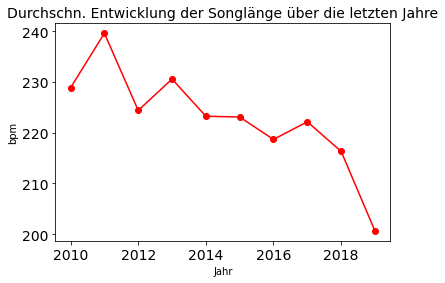

In [232]:
y = grouped_by_year_mean['dur']
x = grouped_by_year_mean.index.to_list()

plt.plot(x, y, color='red', marker='o')
plt.title('Durchschn. Entwicklung der Songlänge über die letzten Jahre', fontsize = 14)
plt.xlabel('Jahr')
plt.ylabel('bpm')
plt.show()

Wir können diesen Vergleich nun noch anstellen mit den Songs, die im Spotify-Datenset und im Youtube-Datenset vorkommen:

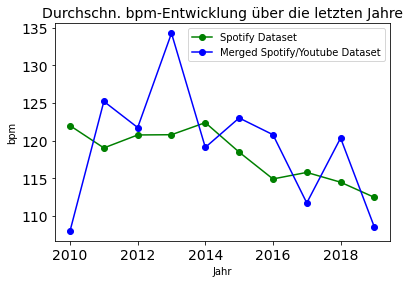

In [233]:
grouped_by_year_mean_youtube_spotify = df_spotify_youtube.groupby(['year']).mean()

y1 = grouped_by_year_mean['bpm']
y2 = grouped_by_year_mean_youtube_spotify['bpm']
x = grouped_by_year_mean.index.to_list()

plt.plot(x, y1, color='green', marker='o', label = 'Spotify Dataset')
plt.plot(x, y2, color='blue', marker='o', label = 'Merged Spotify/Youtube Dataset')
plt.title('Durchschn. bpm-Entwicklung über die letzten Jahre', fontsize = 14)
plt.xlabel('Jahr')
plt.ylabel('bpm')
plt.legend()


#Weil vermutlich gewünscht hier noch der Export der Grafik in ein Excel (das habe ich "ergoogelt")
plt.savefig('Workingdata/plot_3_1.png')
workbook = xlsxwriter.Workbook('Workingdata/Result_Question_03_1.xlsx')
worksheet = workbook.add_worksheet()
worksheet.insert_image('A1', 'Workingdata/plot_3_1.png')
workbook.close()


plt.show() #.show() muss nach .savefig() kommen, nach .show() wird das img geschlossen und aus dem Memory gelöscht

#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_03_1.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_03_1.xlsx
!rm Workingdata/plot_3_1.png

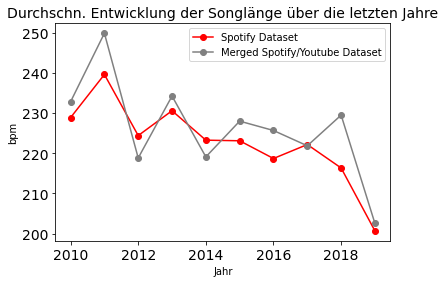

In [234]:
y1 = grouped_by_year_mean['dur']
y2 = grouped_by_year_mean_youtube_spotify['dur']
x = grouped_by_year_mean.index.to_list()

plt.plot(x, y1, color='red', marker='o', label = 'Spotify Dataset')
plt.plot(x, y2, color='grey', marker='o', label = 'Merged Spotify/Youtube Dataset')
plt.title('Durchschn. Entwicklung der Songlänge über die letzten Jahre', fontsize = 14)
plt.xlabel('Jahr')
plt.ylabel('bpm')
plt.legend()

#Weil vermutlich gewünscht hier noch der Export der Grafik in ein Excel (das habe ich "ergoogelt")
plt.savefig('Workingdata/plot_3_2.png')
workbook = xlsxwriter.Workbook('Workingdata/Result_Question_03_2.xlsx')
worksheet = workbook.add_worksheet()
worksheet.insert_image('A1', 'Workingdata/plot_3_2.png')
workbook.close()

plt.show()

#Wir wollen ja die (mühsamen) Vorgaben befolgend und Kopieren dieses File in den richtig beannten Folder
!cp Workingdata/Result_Question_03_2.xlsx ../Gerhard_Tobias_Data
!rm Workingdata/Result_Question_03_2.xlsx
!rm Workingdata/plot_3_2.png

Wie können wir die Ergebnisse nun interpretieren? Spannend ist, dass die durchschnittlichen Beats per Minute sowie auch die durchschnittliche Songdauer im Schnitt sinken. Wie das zu erklären ist? Keine Ahnung, vielleicht sehnt sich der Mensch nach weniger Stress & Tempo im Allgemeinen.